In [1]:
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import os, sys

In [2]:
from nmt.model import define_nmt

In [3]:
from utils.data_helper import read_data, sents2sequences, get_data
from utils.model_helper import plot_attention_weights
from utils.logger import get_logger
from utils.config import Config

In [4]:
import pickle 

In [5]:
config = Config()

logger = get_logger("examples.nmt.train", config.LOGS_DIR)

examples.nmt.train | INFO | Started log logs/examples.nmt.train


In [6]:
batch_size = 64
hidden_size = 96
en_timesteps, fr_timesteps = 20, 20

In [7]:
def preprocess_data(en_tokenizer, fr_tokenizer, en_text, fr_text, en_timesteps, fr_timesteps):
    """ Preprocessing data and getting a sequence of word indices """

    en_seq = sents2sequences(en_tokenizer, en_text, reverse=False, padding_type='pre', pad_length=en_timesteps)
    fr_seq = sents2sequences(fr_tokenizer, fr_text, pad_length=fr_timesteps)
    logger.info('Vocabulary size (English): {}'.format(np.max(en_seq)+1))
    logger.info('Vocabulary size (French): {}'.format(np.max(fr_seq)+1))
    logger.debug('En text shape: {}'.format(en_seq.shape))
    logger.debug('Fr text shape: {}'.format(fr_seq.shape))

    return en_seq, fr_seq

In [8]:
def train(full_model, en_seq, fr_seq, batch_size, n_epochs=10):
    """ Training the model """

    losses_ep = []
    for ep in range(n_epochs):
        losses = []
        for bi in range(0, en_seq.shape[0] - batch_size, batch_size):

            en_onehot_seq = to_categorical(en_seq[bi:bi + batch_size, :], num_classes=en_vsize)
            fr_onehot_seq = to_categorical(fr_seq[bi:bi + batch_size, :], num_classes=fr_vsize)

            full_model.train_on_batch([en_onehot_seq, fr_onehot_seq[:, :-1, :]], fr_onehot_seq[:, 1:, :])

            l = full_model.evaluate([en_onehot_seq, fr_onehot_seq[:, :-1, :]], fr_onehot_seq[:, 1:, :],
                                    batch_size=batch_size, verbose=0)

            losses.append(l)
            
        losses_ep.append(l)
        if (ep + 1) % 1 == 0:
            logger.info("Loss in epoch {}: {}".format(ep + 1, np.mean(losses)))
    return losses_ep, losses

In [9]:
def infer_nmt(encoder_model, decoder_model, test_en_seq, en_vsize, fr_vsize):
    """
    Infer logic
    :param encoder_model: keras.Model
    :param decoder_model: keras.Model
    :param test_en_seq: sequence of word ids
    :param en_vsize: int
    :param fr_vsize: int
    :return:
    """

    test_fr_seq = sents2sequences(fr_tokenizer, ['sos'], fr_vsize)
    test_en_onehot_seq = to_categorical(test_en_seq, num_classes=en_vsize)
    test_fr_onehot_seq = np.expand_dims(to_categorical(test_fr_seq, num_classes=fr_vsize), 1)

    enc_outs, enc_last_state = encoder_model.predict(test_en_onehot_seq)
    dec_state = enc_last_state
    attention_weights = []
    fr_text = ''
    for i in range(20):

        dec_out, attention, dec_state = decoder_model.predict([enc_outs, dec_state, test_fr_onehot_seq])
        dec_ind = np.argmax(dec_out, axis=-1)[0, 0]

        if dec_ind == 0:
            break
        test_fr_seq = sents2sequences(fr_tokenizer, [fr_index2word[dec_ind]], fr_vsize)
        test_fr_onehot_seq = np.expand_dims(to_categorical(test_fr_seq, num_classes=fr_vsize), 1)

        attention_weights.append((dec_ind, attention))
        fr_text += fr_index2word[dec_ind] + ' '

    return fr_text, attention_weights


In [10]:
tr_en_text, tr_fr_text, ts_en_text, ts_fr_text = get_data(train_size=1)

In [11]:
np.shape(tr_en_text)

(1,)

In [12]:
debug = False#True
""" Hyperparameters """

train_size = 100000 if not debug else 10000
filename = ''

tr_en_text, tr_fr_text, ts_en_text, ts_fr_text = get_data(train_size=train_size)

""" Defining tokenizers """
en_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK')
en_tokenizer.fit_on_texts(tr_en_text)

fr_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK')
fr_tokenizer.fit_on_texts(tr_fr_text)

""" Getting preprocessed data """
en_seq, fr_seq = preprocess_data(en_tokenizer, fr_tokenizer, tr_en_text, tr_fr_text, en_timesteps, fr_timesteps)
en_vsize = max(en_tokenizer.index_word.keys()) + 1
fr_vsize = max(fr_tokenizer.index_word.keys()) + 1

examples.nmt.train | INFO | Vocabulary size (English): 201
examples.nmt.train | INFO | Vocabulary size (French): 345


```
Q. Saving Tokenizer object to file...
A. The most common way is to use either pickle or joblib. 
https://stackoverflow.com/a/45737582
```

In [13]:
with open('./out/en_tokenizer.pickle', 'wb') as handle:
    pickle.dump(en_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./out/fr_tokenizer.pickle', 'wb') as handle:
    pickle.dump(fr_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
print(np.shape(en_seq), np.shape(fr_seq))
print(en_vsize, fr_vsize)

(100000, 20) (100000, 20)
201 345


In [15]:
""" Defining the full model """
full_model, infer_enc_model, infer_dec_model = define_nmt(
    hidden_size=hidden_size, batch_size=batch_size,
    en_timesteps=en_timesteps, fr_timesteps=fr_timesteps,
    en_vsize=en_vsize, fr_vsize=fr_vsize)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(64, 20, 201)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(64, 19, 345)]      0                                            
__________________________________________________________________________________________________
encoder_gru (GRU)               [(64, 20, 96), (64,  85824       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (GRU)               [(64, 19, 96), (64,  127296      decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]     

In [16]:
n_epochs = 10 if not debug else 3
losses_ep, losses = train(full_model, en_seq, fr_seq, batch_size, n_epochs)

examples.nmt.train | INFO | Loss in epoch 1: 1.066084914386425
examples.nmt.train | INFO | Loss in epoch 2: 0.09806231110954178
examples.nmt.train | INFO | Loss in epoch 3: 0.048461814290544594
examples.nmt.train | INFO | Loss in epoch 4: 0.03268215319537647
examples.nmt.train | INFO | Loss in epoch 5: 0.02493855033771024
examples.nmt.train | INFO | Loss in epoch 6: 0.02025751924474942
examples.nmt.train | INFO | Loss in epoch 7: 0.016707432868612617
examples.nmt.train | INFO | Loss in epoch 8: 0.013918775346347162
examples.nmt.train | INFO | Loss in epoch 9: 0.01186647714743517
examples.nmt.train | INFO | Loss in epoch 10: 0.010216332494910859


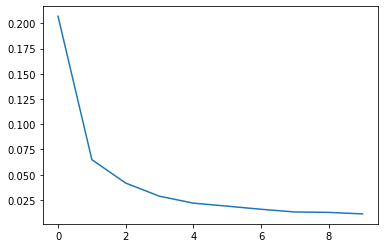

In [17]:
import matplotlib.pyplot as plt
plt.plot(losses_ep)

In [18]:
""" Save model """
if not os.path.exists(config.MODELS_DIR):
    os.mkdir(config.MODELS_DIR)
full_model.save(os.path.join(config.MODELS_DIR, 'nmt.h5'))

infer_enc_model.save(os.path.join(config.MODELS_DIR, 'nmt_infer_enc_model.h5'))
infer_dec_model.save(os.path.join(config.MODELS_DIR, 'nmt_infer_dec_model.h5'))


In [19]:
""" Index2word """
en_index2word = dict(zip(en_tokenizer.word_index.values(), en_tokenizer.word_index.keys()))
fr_index2word = dict(zip(fr_tokenizer.word_index.values(), fr_tokenizer.word_index.keys()))

""" Inferring with trained model """
idx = 110
test_en = ts_en_text[idx]
logger.info('Translating: {}'.format(test_en))

test_en_seq = sents2sequences(en_tokenizer, [test_en], pad_length=en_timesteps)
test_fr, attn_weights = infer_nmt(
    encoder_model=infer_enc_model, decoder_model=infer_dec_model,
    test_en_seq=test_en_seq, en_vsize=en_vsize, fr_vsize=fr_vsize)
logger.info('\tFrench: {}'.format(test_fr))


examples.nmt.train | INFO | Translating: my most loved fruit is the lime , but his most loved is the mango .

examples.nmt.train | INFO | 	French: la mangue est jamais mon fruit aimé mais la chaux est son plus aimé eos 


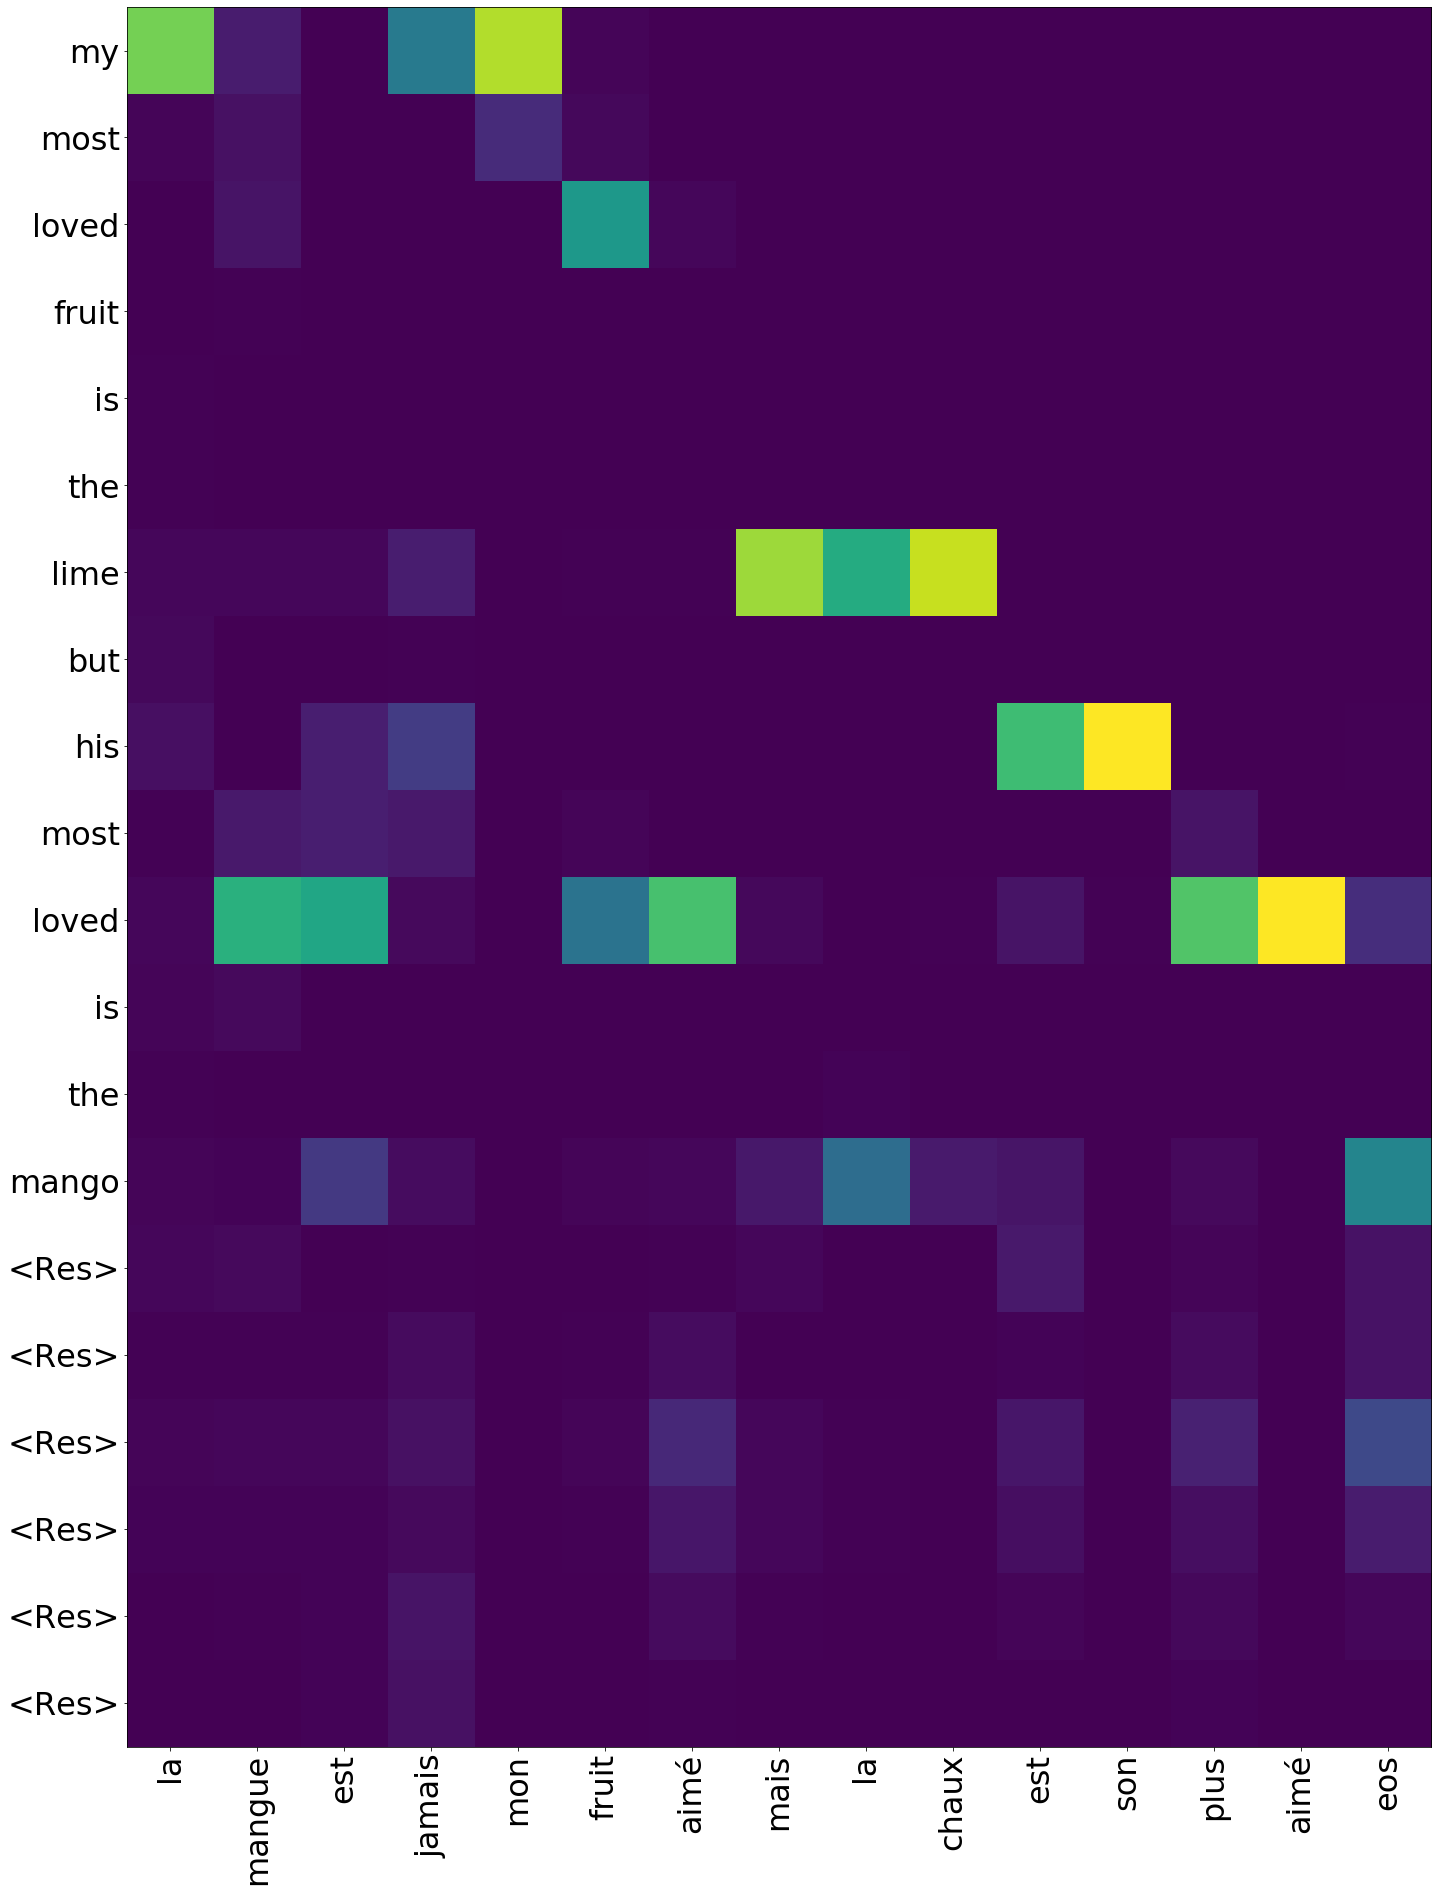

In [20]:
""" Attention plotting """
plot_attention_weights(test_en_seq, attn_weights, en_index2word, fr_index2word)